In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn
import torch.optim as optim

import datasets, transforms, RajaramanModel, pytorch_msssim

flag_debug = False
flag_load_previous_save = False

# Input Directories
data_BSE = "D:/data/JSRT/augmented/train/target/"
data_normal = "D:/data/JSRT/augmented/train/source/"
#data_BSE = "G:/DanielLam/JSRT/augmented/train/target"
#data_normal = "G:/DanielLam/JSRT/augmented/train/source"

# Save directories:
output_save_directory = Path("./runs/Rajaraman_ResNet/v1")
output_save_directory.mkdir(parents=True, exist_ok=True)
PATH_SAVE_NETWORK_INTERMEDIATE = os.path.join(output_save_directory, 'network_intermediate.tar' )
PATH_SAVE_NETWORK = os.path.join(output_save_directory, 'network_final.pt')

# Image Size:
image_spatial_size = (256,256)
_batch_size = 5
test_length = 10

# Optimisation
lr_ini = 0.001
beta1 = 0.9
beta2 = 0.999

# Training
total_num_epochs = 150

# Weight Initialisation
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        #nn.init.normal_(m.weight.data, 0., 0.02)
        nn.init.kaiming_normal_(m.weight.data,0)
        try:
            nn.init.constant_(m.bias.data, 0.)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.)

## Code for putting things on the GPU
ngpu = 1 #torch.cuda.device_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

cpu


(3990, 10)


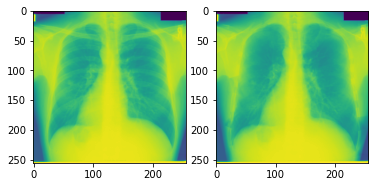

In [2]:
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Data Loader
discriminator_keys_images = ["source", "boneless"]
target_key = "boneless"
ds = datasets.JSRT_CXR(data_normal, data_BSE,
                         transform=tvtransforms.Compose([
                             transforms.RescalingNormalisation(discriminator_keys_images,(0,1)),
                             transforms.RandomIntensityComplement(discriminator_keys_images, probability=0.5),
                             transforms.Rescale(image_spatial_size, discriminator_keys_images, None),
                             transforms.ToTensor(discriminator_keys_images),
                             ])
                      )

# SPLIT DATA INTO TRAINING/VALIDATION SET
lengths=(len(ds)-test_length, test_length)
print(lengths)
ds_training, ds_val = torch.utils.data.random_split(ds, lengths)

dl_training = DataLoader(ds_training, batch_size=_batch_size,
                         shuffle=True, num_workers=0)

dl_validation = DataLoader(ds_val, batch_size=1,
                         shuffle=True, num_workers=0)
fixed_val_sample = next(iter(dl_validation))

fig, ax = plt.subplots(1,2)
ax[0].imshow(fixed_val_sample["source"][0,0,:])
ax[1].imshow(fixed_val_sample["boneless"][0,0,:])
plt.show()

In [3]:
## Implementation of network and losses
input_array_size = (_batch_size, 1, image_spatial_size[0], image_spatial_size[1])
net = RajaramanModel.ResNet_BS(input_array_size)
# Initialise weights
net.apply(weights_init)

# Multi-GPU
if (device.type == 'cuda') and (ngpu > 1):
    print("Neural Net on GPU")
    net = nn.DataParallel(net, list(range(ngpu)))
net = net.to(device)

# Optimiser
optimizer = optim.Adam(net.parameters(), lr=lr_ini, betas=(beta1, beta2))

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=10, 
                                                 threshold=0.0001, min_lr=0.00001, verbose=True)

# Gusarev Loss
def criterion_Rajaraman(testImage, referenceImage, alpha=0.84):
    """
    Gusarev et al. 2017. Deep learning models for bone suppression in chest radiographs.  IEEE Conference on Computational Intelligence in Bioinformatics and Computational Biology.
    """
    mae = nn.L1Loss() # L2 used for easier optimisation c.f. L1
    mae_loss = mae(testImage, referenceImage)
    msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1, normalize='relu')
    msssim_loss = 1 - msssim(testImage, referenceImage)
    total_loss = (1-alpha)*mae_loss + alpha*msssim_loss
    return total_loss, mae_loss, msssim_loss

In [4]:
# Training
epochs_list = []
img_list = []
loss_list = []
reals_shown = []
validation_loss_per_epoch_list = []
training_loss_per_epoch_list = []
ssim_training_list=[]
ssim_val_list = []
# For each epoch
print(target_key)

# optionally resume from a checkpoint
if flag_load_previous_save:
    if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
        print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
        checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE)
        start_epoch = checkpoint['epoch_next']
        reals_shown_now = checkpoint['reals_shown']
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                            start_epoch, reals_shown_now))
        print(scheduler)
    else:
        print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
        raise RuntimeError("No checkpoint found at specified path.")
else:
    print("FLAG: NO CHECKPOINT LOADED.")
    reals_shown_now = 0
    start_epoch=0

# Loop variables
flag_break = False # when debugging, this will automatically go to True
iters = 0
net.train()
for param in net.parameters():
    param.requires_grad = True
for epoch in range(start_epoch, total_num_epochs):
    print(optimizer.param_groups[0]['lr'])
    for i, data in enumerate(dl_training):
        # Training
        net.zero_grad()
        noisy_data = data["source"].to(device)
        cleaned_data = net(noisy_data)
        loss, maeloss, msssim_loss = criterion_Rajaraman(cleaned_data, data[target_key].to(device))
        loss.backward() # calculate gradients
        optimizer.step() # optimiser step along gradients
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tTotal Loss: %.4f\tMSELoss: %.4f\tMSSSIM Loss: %.4f'
                  % (epoch, total_num_epochs, i, len(dl_training),
                     loss.item(), mseloss.item(), msssim_loss.item()))
        # Record generator output
        if reals_shown_now%(100*_batch_size)==0:
            with torch.no_grad():
                val_cleaned = net(fixed_val_sample["source"].to(device)).detach().cpu()
            print("Printing to img_list")
            img_list.append(vutils.make_grid(val_cleaned, padding=2, normalize=True))
        iters +=1
        reals_shown_now += _batch_size
        reals_shown.append(reals_shown_now)
        loss_list.append(loss.item()) # training loss
        
        if flag_debug and iters>=10:
            flag_break = True
            break
    
    # Training and Validation Loss and Accuracy
    with torch.no_grad():
        # Training
        noisy_training_data = data["source"][0,:].to(device)
        true_training_data = data[target_key][0,:]
        cleaned_training_data = net(noisy_training_data)
        loss, maeloss, msssim_loss = criterion_Rajaraman(cleaned_training_data, true_training_data.to(device))
        training_loss_per_epoch_list.append(loss.item())
        ssim_training = skimage.metrics.structural_similarity(cleaned_training_data.cpu().detach().numpy(), true_training_data.numpy())
        ssim_training_list.append(ssim_training)
        
        # Validation
        sample = next(iter(dl_validation))
        noisy_val_data = sample["source"][0,:].to(device)
        true_val_data = sample[target_key][0,:]
        cleaned_val_data = net(noisy_val_data)
        loss, maeloss, msssim_loss = criterion_Rajaraman(cleaned_val_data, true_val_data.to(device))
        validation_loss_per_epoch_list.append(loss.item())
        ssim_val = skimage.metrics.structural_similarity(cleaned_val_data.cpu().detach().numpy(), true_val_data.numpy())
        ssim_val_list.append(ssim_val)
    
    epochs_list.append(epoch)
    # LR Scheduler after epoch
    scheduler.step()
    
    # Save the network in indications
    if epoch % 5 == 0:
        if not flag_debug:
            #torch.save(net.state_dict(), PATH_SAVE_NETWORK_INTERMEDIATE)
            torch.save({
            'epochs_completed': epoch+1,
            'epoch_next': epoch+1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler_state_dict': scheduler.state_dict(),
            'reals_shown': reals_shown_now
            }, PATH_SAVE_NETWORK_INTERMEDIATE)
            print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE))
    if flag_break:
        break

if not flag_debug:
    torch.save(net.state_dict(), PATH_SAVE_NETWORK)
    

boneless
FLAG: NO CHECKPOINT LOADED.
0.001
[0/150][0/798]	Total Loss: 0.8894	MSELoss: 0.3087	MSSSIM Loss: 1.0000
Printing to img_list


KeyboardInterrupt: 

In [ ]:
%matplotlib inline
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Accuracy
plt.figure(figsize=(10,5))
plt.title("SSIM")
plt.plot(epochs_list, ssim_training_list, label='training')
plt.plot(epochs_list, ssim_val_list, label='validation')
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.legend()


# Loss for training
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(reals_shown, loss_list)
plt.xlabel("reals_shown")
plt.ylabel("Training Loss")
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "training_loss"+".png"))

# Final Model:
with torch.no_grad():
    input_image = fixed_val_sample['source']
    input_images = vutils.make_grid(input_image[0:1,:,:,:], padding=2, normalize=True)
    target_images = vutils.make_grid(fixed_val_sample['boneless'][0:1,:,:,:], padding=2, normalize=True)
    net = net.cpu()
    output_image = net(input_image[0:1,:,:,:]).detach().cpu()
    output_images = vutils.make_grid(output_image, padding=2, normalize=True)
print(str(torch.max(output_images)) + "," + str(torch.min(output_images)))
plt.figure(1)
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(np.transpose(input_images, (1,2,0)), vmin=0, vmax=1)
ax[0].set_title("Source")
ax[0].axis("off")
ax[1].imshow(np.transpose(output_images, (1,2,0)), vmin=0, vmax=1)
ax[1].set_title("Suppressed")
ax[1].axis("off")
ax[2].imshow(np.transpose(target_images, (1,2,0)), vmin=0, vmax=1)
ax[2].set_title("Ideal Bone-suppressed")
ax[2].axis("off")
plt.show
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_validation_ComparisonImages"+".png"))

# ANIMATED VALIDATION IMAGE
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.axis("off")
ims = []
training_ims_shown = []
for i, im in enumerate(img_list):
    if i % 50 == 0:  # controls how many images are printed into the animation
        training_ims_shown = i*(100*_batch_size)
        frame = ax.imshow(np.transpose(im,(1,2,0)))
        t = ax.annotate("Reals shown: {}".format(training_ims_shown), (0.5,1.02), xycoords="axes fraction")
        ims.append([frame, t])
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
if not flag_debug:
    ani.save(os.path.join(output_save_directory, current_date+"_animation.mp4"), dpi=300)